In [1]:
%pylab inline
plt.rcParams['figure.figsize'] = (25, 10)

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree,
    plot_signal_histogram, earth_plot)

## Enter your settings here

In [3]:
data_folder = Path("/home/bathiany/Sebastian/datamining/edges/obsscan")
data_set = DataSet([data_folder / 'ice_conc_nh_ease2-250_cdr-v2p0_remapbilt200_September.nc'], 'ice_conc')

#dataset goes from 1979 - 2015

sigma_d = unit('200 km')
sigma_t = unit('5 year')

gamma = 1000000
scaling_factor = gamma * unit('1 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

## Load the data

In [4]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(86396.5 year, 66.1624 km, 63.54 km) per pixel
1979-09-15, 1980-09-15, 1981-09-15,  ...
time steps: max 31622400.0 min 31536000.0


### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [5]:
yearly_data_set = data_set
box = yearly_data_set.box
data = yearly_data_set.data

smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])

In [6]:
my_cmap = matplotlib.cm.get_cmap('rainbow')  #YlGnBu
my_cmap.set_under('w')

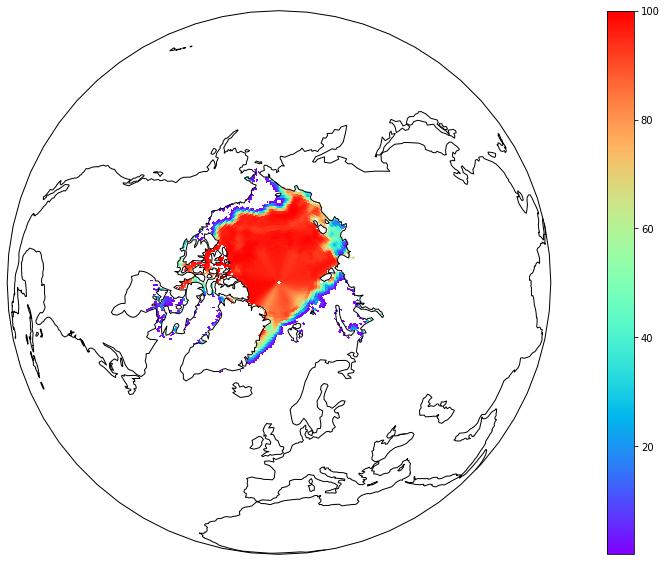

In [7]:
plot_orthographic_np(box, yearly_data_set.data[0], cmap=my_cmap, vmin=0.1) #1979


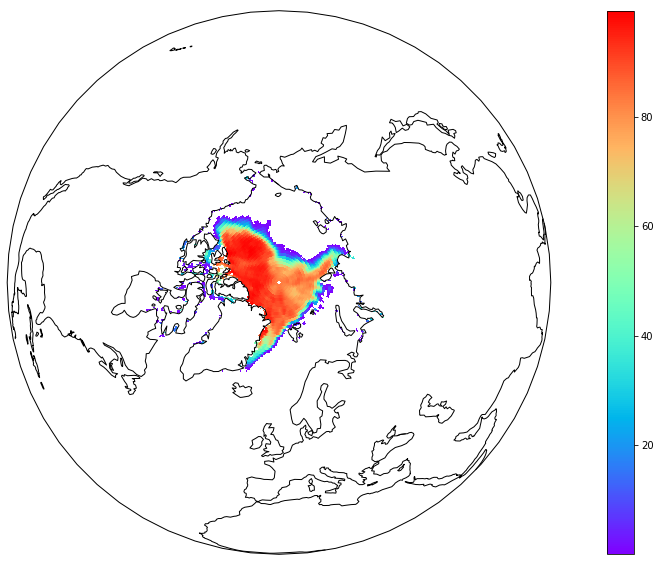

In [8]:
plot_orthographic_np(box, yearly_data_set.data[28], cmap=my_cmap, vmin=0.1) #2007

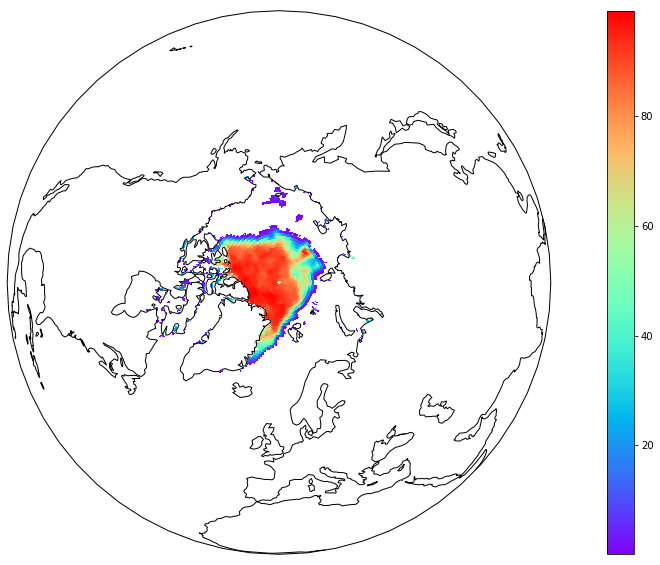

In [9]:
plot_orthographic_np(box, yearly_data_set.data[33], cmap=my_cmap, vmin=0.1) #2012


### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [10]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)

### Determine hysteresis settings

In [11]:
signal = 1/sb[3]

In [12]:
## quartiles

signalarray = np.asarray(signal).reshape(-1)
signal_no0 = np.ma.masked_equal(signalarray,0)
signal_no0=signal_no0.compressed()

#np.percentile(signal_no0, [25, 50, 75, 100])

In [13]:
## There is no control data for observations => must choose thresholds based on data itself.
# Here, use 75 and 50%ile (quartiles 2 and 3)

upper_threshold=np.percentile(signal_no0, 75)
lower_threshold=np.percentile(signal_no0, 50)

In [14]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [15]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).astype('float32')
dat[:,:,:,3] = sb[3].transpose([2,1,0])
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy().astype('float32')

In [16]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

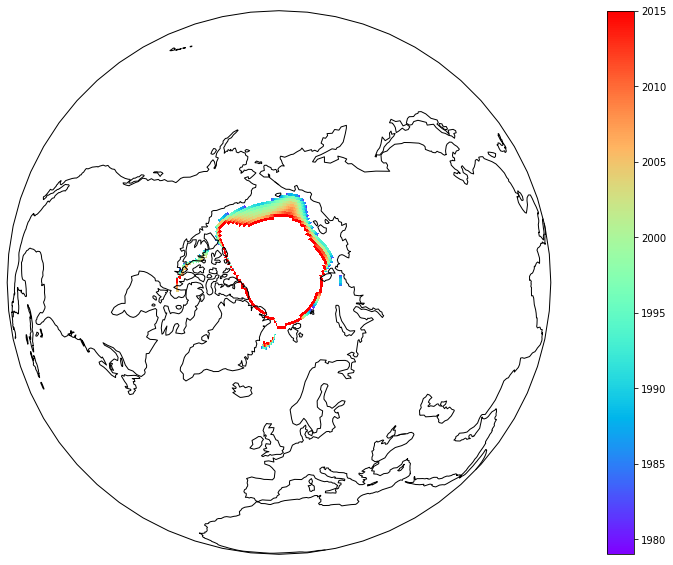

In [17]:
years = np.array([d.year for d in box.dates])
my_cmap = matplotlib.cm.get_cmap('rainbow')  #YlGnBu
my_cmap.set_under('w')
plot_orthographic_np(box, (years[:,None,None]*m).max(axis=0),  cmap=my_cmap, vmin=1979)